In [9]:
import numpy as np
import pandas as pd

In [10]:
captions = np.load('data/mscoco/all_captions.npy')
captions = [c[:5] for c in captions]
sentences = []
for c in captions:
    sentences += c

In [6]:
# "GOOGLE ELMO" sentence embeddings 

import tensorflow as tf
import tensorflow_hub as hub

# ELMO 
elmo = hub.Module("https://tfhub.dev/google/elmo/1", trainable=False)
elmo_input = tf.placeholder(tf.string)
elmo_embeddings = elmo(elmo_input, signature="default", as_dict=True)["default"]
def get_elmo_emb(sentences):
    batch_size = 64
    ix = 0
    result = []
    while ix < len(sentences):
        result.append(session.run(elmo_embeddings,
                                   feed_dict={elmo_input: sentences[ix: min(ix + batch_size, len(sentences))]}))
        ix += batch_size
    return np.concatenate(result, axis=0)

# USE 
unsent = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/1")
unsent_input = tf.placeholder(tf.string)
unsent_embeddings = unsent(unsent_input)
def get_unsent_emb(sentences):
    return session.run(unsent_embeddings, feed_dict={unsent_input: sentences})


#SESSION
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
session.run([tf.global_variables_initializer(), tf.tables_initializer()])

INFO:tensorflow:Initialize variable module_2/aggregation/scaling:0 from checkpoint b'/tmp/tfhub_modules/0eadd30f548cbfd3065119697ded6bb381668285/variables/variables' with aggregation/scaling
INFO:tensorflow:Initialize variable module_2/aggregation/weights:0 from checkpoint b'/tmp/tfhub_modules/0eadd30f548cbfd3065119697ded6bb381668285/variables/variables' with aggregation/weights
INFO:tensorflow:Initialize variable module_2/bilm/CNN/W_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/0eadd30f548cbfd3065119697ded6bb381668285/variables/variables' with bilm/CNN/W_cnn_0
INFO:tensorflow:Initialize variable module_2/bilm/CNN/W_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/0eadd30f548cbfd3065119697ded6bb381668285/variables/variables' with bilm/CNN/W_cnn_1
INFO:tensorflow:Initialize variable module_2/bilm/CNN/W_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/0eadd30f548cbfd3065119697ded6bb381668285/variables/variables' with bilm/CNN/W_cnn_2
INFO:tensorflow:Initialize variable module_2/bilm/CNN/W_cnn_3:0

INFO:tensorflow:Initialize variable module_3/Embeddings_en/sharded_0:0 from checkpoint b'/tmp/tfhub_modules/c6f5954ffa065cdb2f2e604e740e8838bf21a2d3/variables/variables' with Embeddings_en/sharded_0
INFO:tensorflow:Initialize variable module_3/Embeddings_en/sharded_1:0 from checkpoint b'/tmp/tfhub_modules/c6f5954ffa065cdb2f2e604e740e8838bf21a2d3/variables/variables' with Embeddings_en/sharded_1
INFO:tensorflow:Initialize variable module_3/Embeddings_en/sharded_10:0 from checkpoint b'/tmp/tfhub_modules/c6f5954ffa065cdb2f2e604e740e8838bf21a2d3/variables/variables' with Embeddings_en/sharded_10
INFO:tensorflow:Initialize variable module_3/Embeddings_en/sharded_11:0 from checkpoint b'/tmp/tfhub_modules/c6f5954ffa065cdb2f2e604e740e8838bf21a2d3/variables/variables' with Embeddings_en/sharded_11
INFO:tensorflow:Initialize variable module_3/Embeddings_en/sharded_12:0 from checkpoint b'/tmp/tfhub_modules/c6f5954ffa065cdb2f2e604e740e8838bf21a2d3/variables/variables' with Embeddings_en/sharded_12

[None, None]

In [7]:
get_elmo_emb(["the cat is on the mat", "dogs are in the fog"])

array([[ 0.055172  , -0.02187641, -0.17496805, ..., -0.3684806 ,
         0.09267835,  0.23179089],
       [-0.00798454,  0.14567915, -0.23224346, ..., -0.10154841,
         0.08691092,  0.23858926]], dtype=float32)

In [8]:
get_unsent_emb(["The quick brown fox jumps over the lazy dog.",
             "I am a sentence for which I would like to get its embedding"])

array([[ 0.03424731,  0.04210585, -0.01947479, ...,  0.06809645,
        -0.06328977, -0.0475835 ],
       [ 0.03531335, -0.02538425, -0.00788002, ...,  0.08605083,
        -0.06940889, -0.06568888]], dtype=float32)

In [12]:
import torch as t
import utils
from utils.batch_loader import BatchLoader
from model.parameters import Parameters
from model.paraphraser import Paraphraser

class Args(object):
    pass

args = Args()
args.batch_size = 32
args.seq_len=30
args.use_cuda = True

args.use_cuda = True
args.model_name = 'snli_200kit_600_800'

datasets = set()
datasets.add('snli')


sentences = np.array([utils.batch_loader.clean_str(s) for s in sentences])
captions = [[utils.batch_loader.clean_str(s) for s in bucket] for bucket in captions]

batch_loader = BatchLoader(path='', datasets=datasets)
batch_loader.build_input_vocab(sentences)

SNLI: train: 183416, test: 3368
ALL: train: 183416, test: 3368
Found 20514(/21730) words with glove vectors
Vocab size : 20514
Found 30481(/26837) words with glove vectors
Vocab size : 30481


In [4]:
# PARAPHRASER
parameters = Parameters(batch_loader.max_seq_len, batch_loader.vocab_size)
paraphraser = Paraphraser(parameters)

paraphraser.load_state_dict(t.load('saved_models/trained_paraphraser_' + args.model_name))
if args.use_cuda:
    paraphraser = paraphraser.cuda()

In [13]:
# PARAPHRASER EXPAND
def paraphrases_from_sources(sources, use_mean=True):
    result = []
    for s1,s2 in zip(sources[0], sources[1]):
        input = batch_loader.input_from_sentences([[s1],[s2]])
        input = [var.cuda() if args.use_cuda else var for var in input]
        result += [paraphraser.sample_with_input(batch_loader, args.seq_len, args.use_cuda, use_mean, input)]
    
    return result

def paraphrase_expand(X, y, n_paraphrases, pure_paraphrases):
    if n_paraphrases <= 0:
        return X,y
    
    X_gen, y_gen = [], []
    y = np.array(y)
    X = np.array(X)
    for class_id in np.unique(y):
        X_class = X[y == class_id]
        idx = []
        for i in range(len(X_class)):
            for j in range(len(X_class)):
                if i == j and len(X_class) != 1:
                    continue
                idx.append((i,j))
                
        idx = np.array(idx)
        idx = idx[np.random.choice(list(range(len(idx))), n_paraphrases, replace=False)]
        sources = [X_class[idx[:,0]], X_class[idx[:,1]]]
        X_gen += [paraphrases_from_sources(sources)]
        y_gen += [[class_id] * n_paraphrases]
    
    if pure_paraphrases:
        return np.concatenate(X_gen), np.concatenate(y_gen)
    
    X_result = np.concatenate([X] + X_gen)
    y_result = np.concatenate([y] + y_gen)
    
    return X_result, y_result

### infersent

In [ ]:
# build infersent
import torch as t
import sys
sys.path.append('../InferSent/encoder')

INFERSENT_PATH = '../InferSent/encoder/'
GLOVE_PATH = '/home/aleksey.zotov/InferSent/dataset/GloVe/glove.840B.300d.txt'

infersent_model = t.load(INFERSENT_PATH + 'infersent.allnli.pickle', map_location=lambda storage, loc: storage)
# infersent_model = t.load(INFERSENT_PATH + 'infersent.allnli.pickle', map_location={'cuda:1' : 'cuda:0', 'cuda:2' : 'cuda:0'})
# infersent_model = t.load(INFERSENT_PATH + 'infersent.allnli.pickle')
infersent_model.set_glove_path(GLOVE_PATH)
infersent_model.build_vocab(sentences, tokenize=False)
# infersent_model.build_vocab_k_words(K=200000)

# infersent embs
def get_infersent_emb(X):
    embeddings = infersent_model.encode(X, bsize=64, tokenize=False, verbose=False)
    return embeddings

# Some paraphrasing samples

In [6]:
paraphrases_from_sources([
    ['Woman sits near the table with her dog'],
    ['Very old woman is sitting with her child on the table']], use_mean=False)

[' older woman is sitting with her dog in front of the table']

In [7]:
paraphrases_from_sources([
    ['Woman sits near the table with her dog'],
    ['Very old woman is sitting with her child on the table']], use_mean=False)

[' an old woman is sitting on the table with her dog']

In [8]:
paraphrases_from_sources([
    ['man is chopping old wood with an axe'],
    ['very old man is outside']], use_mean=True)

[' older man is outside']

In [9]:
cid = 0
captions[cid][0], captions[cid][1], paraphrases_from_sources([[captions[cid][0]], [captions[cid][1]]], use_mean=True)[0]

('a bicycle replica with a clock as the front wheel',
 'the bike has a clock as a tire',
 ' the bicycle has a marker')

In [10]:
cid = 1
captions[cid][0], captions[cid][1], paraphrases_from_sources([[captions[cid][0]], [captions[cid][1]]], use_mean=True)[0]

('a room with blue walls and a white sink and door',
 'blue and white color scheme in a small bathroom',
 ' there is a room covered in a room')

In [11]:
cid = 1337
captions[cid][0], captions[cid][1], paraphrases_from_sources([[captions[cid][0]], [captions[cid][1]]], use_mean=True)[0]

('a small white toilet sitting in a bathroom',
 'the toilet in the small stall has the lit up',
 ' small inside of the water with the mirror of the mirror')

In [14]:
# GLOVE EMB using batch loader
def get_glove_emb(sentence):
    emb_size = 300
    embed = np.zeros((len(sentence), emb_size))
    for i, s in enumerate(sentence.strip().split()):
        if s in batch_loader.word_vec.keys(): 
            embed[i, :] = batch_loader.word_vec[s]
        else:
            embed[i, :] = batch_loader.word_vec['null']
    return embed

In [46]:
# Build ONEHOT model embeddings
from collections import Counter
vocab_size = 10000
word_counter = Counter((' '.join(sentences)).split())
idx_to_word = [x[0] for x in word_counter.most_common(vocab_size - 1)]
word_to_idx = {v : i for i,v in enumerate(idx_to_word)}

def get_idx_by_word(w):
    if w in word_to_idx:
        return word_to_idx[w]
    return vocab_size - 1

def get_simple_onehot_embs(X):
    embed = []
    for sentence in X:
        result = np.zeros(vocab_size)
        result[[get_idx_by_word(w) for w in sentence.split()]] = 1.0
        embed.append(result)
    return np.array(embed)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

def get_f1_score(y_true, y_pred):
    return precision_recall_fscore_support(y_true=np.array(y_true), y_pred=y_pred)[2]

def split_and_test(classifier, model_function, X_all, y_all, n_samples, n_paraphrases, pure_paraphrases=False):
    n_classes = len(np.unique(y_all))
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, stratify=y_all, train_size=n_samples * n_classes)
    X_train, y_train = paraphrase_expand(X_train, y_train, n_paraphrases, pure_paraphrases)
    predicted_proba = model_function(classifier, X_train, X_test, y_train)
    return np.mean(get_f1_score(y_test, predicted_proba))

In [47]:
def with_embs(emb_function, classifier, X_train, X_test, y_train):
    X_train = emb_function(X_train)
    X_test = emb_function(X_test)
    classifier.fit(X_train, y_train)
    return classifier.predict(X_test)

def onehot_embs_function(classifier, X_train, X_test, y_train):
    return with_embs(get_simple_onehot_embs, classifier, X_train, X_test, y_train)

def infersent_embs_function(classifier, X_train, X_test, y_train):
    return with_embs(get_infersent_emb, classifier, X_train, X_test, y_train)

def bag_of_words_function(classifier, X_train, X_test, y_train):
    get_avg_glove_emb = lambda X: np.array([get_glove_emb(x).mean(axis=0) for x in X])
    return with_embs(get_avg_glove_emb, classifier, X_train, X_test, y_train)

def elmo_embs_function(classifier, X_train, X_test, y_train):
    return with_embs(get_elmo_emb, classifier, X_train, X_test, y_train)

def unsent_embs_function(classifier, X_train, X_test, y_train):
    return with_embs(get_unsent_emb, classifier, X_train, X_test, y_train)

In [17]:
def build_xy_sampled(n_classes):
    assert n_classes <= len(captions)
    sampled_captions_id = np.random.choice(list(range(len(captions))), size=n_classes, replace=False)
    x_all, y_all = [], []
    for i in sampled_captions_id:
        y_all += [i] * len(captions[i])
        for s in captions[i]:
            x_all.append(s)
    return x_all, y_all

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
from tqdm import tqdm
def run(classifier, function, n_samples, n_paraphrases, n_classes, averaging_order, pure_paraphrases):
    result_f1 = []
    for i in tqdm(range(averaging_order), position=0):
        X,y = build_xy_sampled(n_classes)
        result_f1.append(split_and_test(classifier, function, X, y, n_samples, n_paraphrases, pure_paraphrases))
    return np.mean(result_f1), np.std(result_f1)

# paraphrasing VS no-paraphrasing

In [18]:
from sklearn.linear_model import LogisticRegression
logreg_classifier = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=500, C=100, n_jobs=-1)

##  1 sample

In [20]:
run(logreg_classifier, 
    bag_of_words_function, 
    n_samples=1, 
    n_paraphrases=0, 
    n_classes=30, 
    averaging_order=30, 
    pure_paraphrases=False)

100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


(0.6539462748580397, 0.06604705517453359)

In [21]:
run(logreg_classifier,
    bag_of_words_function,
    n_samples=1,
    n_paraphrases=1,
    n_classes=30,
    averaging_order=30,
    pure_paraphrases=False)

100%|██████████| 30/30 [00:52<00:00,  1.76s/it]


(0.6349217864465543, 0.059079898191404946)

## 2 samples 

In [22]:
run(logreg_classifier,
    bag_of_words_function,
    n_samples=2,
    n_paraphrases=0,
    n_classes=30,
    averaging_order=30,
    pure_paraphrases=False)

100%|██████████| 30/30 [00:37<00:00,  1.23s/it]


(0.814659852493186, 0.05307156809327878)

In [23]:
run(logreg_classifier,
    bag_of_words_function,
    n_samples=2,
    n_paraphrases=1,
    n_classes=30,
    averaging_order=30,
    pure_paraphrases=False)

100%|██████████| 30/30 [01:06<00:00,  2.23s/it]


(0.7730055315055316, 0.04833216119069171)

## 3 samples

In [24]:
run(logreg_classifier,
    bag_of_words_function,
    n_samples=3,
    n_paraphrases=0,
    n_classes=30,
    averaging_order=30,
    pure_paraphrases=False)

100%|██████████| 30/30 [00:50<00:00,  1.69s/it]


(0.8257054673721341, 0.061292614074307715)

In [25]:
run(logreg_classifier,
    bag_of_words_function,
    n_samples=3,
    n_paraphrases=3,
    n_classes=30,
    averaging_order=30,
    pure_paraphrases=False)

100%|██████████| 30/30 [02:10<00:00,  4.36s/it]


(0.8217213403880073, 0.05220771190409793)

## 4 samples

In [28]:
run(logreg_classifier,
    bag_of_words_function,
    n_samples=4,
    n_paraphrases=0,
    n_classes=30,
    averaging_order=30,
    pure_paraphrases=False)

100%|██████████| 30/30 [01:03<00:00,  2.11s/it]


(0.8545185185185186, 0.08730719302188548)

In [29]:
run(logreg_classifier,
    bag_of_words_function,
    n_samples=4,
    n_paraphrases=6,
    n_classes=30,
    averaging_order=30,
    pure_paraphrases=False)

100%|██████████| 30/30 [03:31<00:00,  7.04s/it]


(0.8457407407407406, 0.0784322114757844)

In [30]:
paraphrases_from_sources([['a table with a quesadilla salad and drinks'],['a sliced pizza a salad and two milk shakes on a table']], use_mean=True)

[' a table filled with a spoon and a few empty plate at a table']

In [ ]:
# !export CUDA_VISIBLE_DEVICES=1 
!echo $CUDA_VISIBLE_DEVICES

# GLOVE BAG vs USE vs ELMO vs InferSent

In [48]:
from sklearn.linear_model import LogisticRegression
logreg_classifier = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=500, C=100, n_jobs=-1)

In [47]:
# GLOVE BAG
run(logreg_classifier,
    bag_of_words_function,
    n_samples=3, 
    n_paraphrases=0,
    n_classes=30,
    averaging_order=30,
    pure_paraphrases=False)

100%|██████████| 30/30 [00:41<00:00,  1.38s/it]


(0.8315167548500881, 0.06565648855940624)

In [52]:
# %%time
run(logreg_classifier,
    elmo_embs_function,
    n_samples=3, 
    n_paraphrases=0,
    n_classes=30,
    averaging_order=30,
    pure_paraphrases=False)

100%|██████████| 30/30 [03:46<00:00,  7.56s/it]


(0.8194603174603173, 0.06245863466938405)

In [51]:
%%time
run(logreg_classifier,
    unsent_embs_function,
    n_samples=3, 
    n_paraphrases=0,
    n_classes=30,
    averaging_order=30,
    pure_paraphrases=False)

100%|██████████| 30/30 [00:53<00:00,  1.78s/it]

CPU times: user 4min 13s, sys: 24 s, total: 4min 37s
Wall time: 53.4 s


(0.8492010582010583, 0.0662022559821411)

In [53]:
%%time
run(logreg_classifier,
    infersent_embs_function,
    n_samples=3, 
    n_paraphrases=0,
    n_classes=30,
    averaging_order=30,
    pure_paraphrases=False)

100%|██████████| 30/30 [17:56<00:00, 35.88s/it]

CPU times: user 33min 17s, sys: 1min 38s, total: 34min 55s
Wall time: 17min 56s


(0.8873227513227513, 0.05617811021872542)

In [ ]:
(0.896825396825397, 0.046513606386423476)

# RANDOM FOREST 

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
# GLOVE BAG
rf_classifier = RandomForestClassifier(n_estimators=2000, max_depth=7, n_jobs=-1)
run(rf_classifier,
    bag_of_words_function,
    n_samples=3, 
    n_paraphrases=0,
    n_classes=30,
    averaging_order=30,
    pure_paraphrases=False)

100%|██████████| 30/30 [01:38<00:00,  3.28s/it]


(0.7590846560846563, 0.06675281261233544)

In [57]:
# GLOVE BAG
rf_classifier = RandomForestClassifier(n_estimators=3000, n_jobs=-1)
run(rf_classifier,
    bag_of_words_function,
    n_samples=3, 
    n_paraphrases=0,
    n_classes=30,
    averaging_order=30,
    pure_paraphrases=False)

100%|██████████| 30/30 [01:41<00:00,  3.38s/it]


(0.8130264550264549, 0.06428641887827777)

In [58]:
# GLOVE BAG
rf_classifier = RandomForestClassifier(n_estimators=3000, n_jobs=-1)
run(rf_classifier,
    bag_of_words_function,
    n_samples=3, 
    n_paraphrases=0,
    n_classes=30,
    averaging_order=30,
    pure_paraphrases=False)

100%|██████████| 30/30 [02:31<00:00,  5.04s/it]


(0.7950317460317461, 0.057285010573290114)

In [39]:
# 13.1s/it:CPU , 8.5s/it:GPU
# %%time
classifier = RandomForestClassifier(n_estimators=2000, n_jobs=-1)
run(rf_classifier,
    elmo_embs_function,
    n_samples=3, 
    n_paraphrases=0,
    n_classes=30,
    averaging_order=30,
    pure_paraphrases=False)

100%|██████████| 30/30 [01:48<00:00,  3.63s/it]


(0.7960317460317462, 0.06166265231770459)

In [60]:
# session.close()

# Plots

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
colors = ['b', 'g', 'r', 'orange', 'black']
def plots_for_nsources_range(title, names, scores, stds, n_samples):
    plt.figure()
    fig, ax = plt.subplots(figsize=(12,9))
    ax.grid(True)
    plt.title(title, fontsize=14)
    for i in range(len(scores)):
        ax.plot(n_samples, scores[i],'-o', label = names[i], color=colors[i])
        ax.fill_between(n_samples, scores[i] - stds[i], scores[i] + stds[i],alpha=0.10, color=colors[i])
        ax.set_ylabel('F1')
        ax.legend(loc=(0.8,0.1), fontsize=12)
        ax.set_ylabel('between y1 and 0')
        
    plt.xlabel('number of training samples per class', fontsize=12)
    plt.ylabel('F1', fontsize=12)
    plt.savefig('logs/nsources_{}.png'.format(title))
    plt.show()

# EMBS

In [21]:
AVERAGING_ORDER = 50
def process_for_sources_range(name, classifier, function , n_sources_range, n_paraphrases = 0):
    mean = []
    std = []
    for n_sources in tqdm(n_sources_range, position=0):
        cur_mean, cur_std = results = run(classifier,
                        function,
                        n_samples=n_sources,
                        n_paraphrases=n_paraphrases,
                        n_classes=30,
                        averaging_order=AVERAGING_ORDER,
                        pure_paraphrases=False)

        mean.append(cur_mean)
        std.append(cur_std)
    mean = np.array(mean)
    std = np.array(std)
    n_sources_range = np.array(n_sources_range)
    np.save('logs/mscoco_score_{}.npy'.format(name), [mean, std, n_sources_range])
    return mean, std, n_sources_range

In [22]:
from sklearn.linear_model import LogisticRegression
logreg_classifier = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000, n_jobs=-1, C=100)

In [23]:
n_sources_range = [1,2,3,4]

In [24]:
%%time
name = 'glove_logreg'
process_for_sources_range(name, logreg_classifier, bag_of_words_function, n_sources_range, n_paraphrases=0)

  0%|          | 0/50 [00:00<?, ?it/s]/home/aleksey.zotov/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/aleksey.zotov/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 4/4 [03:41<00:00, 55.33s/it]

CPU times: user 26min 35s, sys: 1min 48s, total: 28min 23s
Wall time: 3min 41s


In [25]:
%%time
name = 'elmo_logreg'
process_for_sources_range(name, logreg_classifier, elmo_embs_function, n_sources_range, n_paraphrases=0)

  0%|          | 0/50 [00:00<?, ?it/s]/home/aleksey.zotov/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/aleksey.zotov/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
 58%|█████▊    | 29/50 [03:34<02:35,  7.40s/it]/home/aleksey.zotov/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 4/4 [30:59<00:00, 464.88s/it]

CPU times: user 55min 15s, sys: 2min 31s, total: 57min 47s
Wall time: 30min 59s


In [27]:
%%time
name = 'unsent_logreg'
process_for_sources_range(name, logreg_classifier, unsent_embs_function, n_sources_range, n_paraphrases=0)

  0%|          | 0/50 [00:00<?, ?it/s]/home/aleksey.zotov/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
  6%|▌         | 3/50 [00:01<00:29,  1.58it/s]/home/aleksey.zotov/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 4/4 [04:51<00:00, 72.77s/it]

CPU times: user 27min 54s, sys: 2min 42s, total: 30min 36s
Wall time: 4min 51s


In [30]:
%%time
name = 'infersent_logreg'
process_for_sources_range(name, logreg_classifier, infersent_embs_function, n_sources_range, n_paraphrases=0)

  0%|          | 0/50 [00:00<?, ?it/s]/home/aleksey.zotov/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
../InferSent/encoder/models.py:206: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  sentences[stidx:stidx + bsize]), volatile=True)
/home/aleksey.zotov/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 4/4 [1:42:24<00:00, 1536.06s/it]

CPU times: user 3h 28min 3s, sys: 9min 28s, total: 3h 37min 32s
Wall time: 1h 42min 24s


In [48]:
%%time
name = 'onehot_logreg_50'
logreg_classifier = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=50, n_jobs=-1, C=50)
process_for_sources_range(name,logreg_classifier, onehot_embs_function, n_sources_range, n_paraphrases=0)

  0%|          | 0/50 [00:00<?, ?it/s]/home/aleksey.zotov/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/aleksey.zotov/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/aleksey.zotov/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 4/4 [27:51<00:00, 417.92s/it]

CPU times: user 51min 4s, sys: 2min 1s, total: 53min 6s
Wall time: 27min 51s


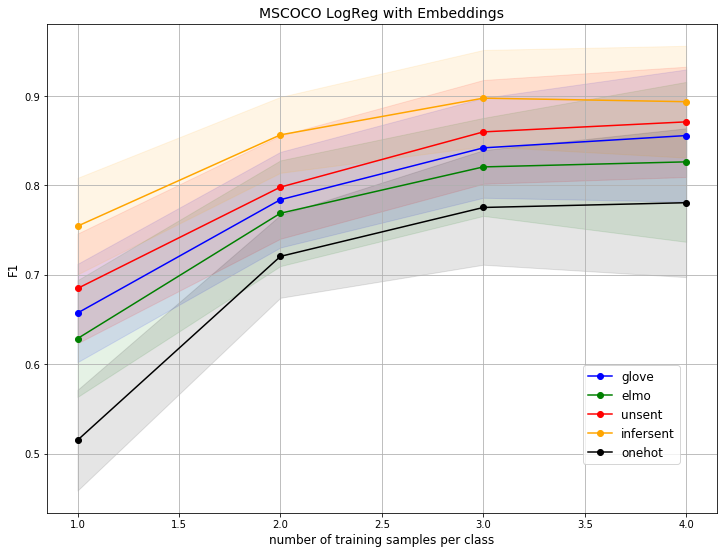

In [51]:
glove = np.load('logs/mscoco_score_glove_logreg.npy')
elmo = np.load('logs/mscoco_score_elmo_logreg.npy')
unsent = np.load('logs/mscoco_score_unsent_logreg.npy')
infersent = np.load('logs/mscoco_score_infersent_logreg.npy')
onehot = np.load('logs/mscoco_score_onehot_logreg_50.npy')
names = ['glove','elmo','unsent','infersent','onehot']
data =  [glove , elmo , unsent , infersent , onehot]
scores = [d[0] for d in data]
stds = [d[1] for d in data]
ranges = data[0][2]
    
plots_for_nsources_range('MSCOCO LogReg with Embeddings', names, scores, stds, ranges)